In [1]:
import os
import json
import numpy as np
import pickle 
import tqdm
import tarfile
from scipy import sparse
from collections import defaultdict
from pprint import pprint
from collections import Counter

In [2]:
def load_data(path):
    with open(path, 'rb') as fp:
        data = pickle.load(fp)

    return data["xs"], data["ys"]

def load_weights_dict(path):
    with open(path, 'rb') as fp:
        weights_dict = pickle.load(fp)
    return weights_dict

def get_dummy_classifier():
    return DummyClassifier(strategy="constant", constant=0)

In [6]:
weights_path = "../data/weights_dict.pkl"
data_path = "../data/dataset_positions_all.pkl" 

wd = load_weights_dict(weights_path)

xs, ys = load_data(data_path)

xs.keys()



dict_keys([59, 44, 135, 97, 101, 19, 84, 81, 75, 74, 33, 109, 129, 123, 104, 91, 63, 106, 4, 5, 93, 34, 71, 114, 69, 35, 6, 55, 25, 112, 107, 27, 126, 8, 52, 30, 85, 80, 14, 68, 10, 64, 86, 16, 50, 94, 20, 100, 119, 7, 3, 98, 39, 9, 32, 29, 67, 46, 28, 88, 54, 43, 73, 108, 26, 18, 11, 99, 15, 76, 2, 45, 22, 72, 42, 47, 128, 53, 13, 121, 96, 102, 21, 1, 36, 17, 70, 48, 41, 77, 62, 31, 60, 56, 23, 58, 37, 51, 103, 40, 38, 83, 87, 49, 113, 111, 110, 57, 105, 65, 12, 120, 78, 92, 82, 66, 89, 61, 95, 90, 79])

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier

# output_path = "../data/dataset_positions_winners.pkl" 
data_path = "../data/dataset_positions_all_no_teammates.pkl" 
out_path = "../data/logreg_clfs_all_no_teammates.pkl"
weights_path = "../data/weights_dict.pkl"
xs, ys = load_data(data_path)
weights_dict = load_weights_dict(weights_path)

assert not os.path.exists(out_path)

clfs = {}
scores = {}
scores_dict = {}
n_features = np.vstack(xs[1]).shape[1]
for hid in tqdm.tqdm(xs):
    try:
        x = np.vstack(xs[hid])
        y = np.hstack(ys[hid])
        
        class_weight = {e:v for e, v in enumerate(weights_dict[hid])}
        unique = np.unique(np.hstack(ys[hid]))

        for class_role in [1, 2, 3, 4, 5]:
            if not class_role in unique.tolist():
                print('added classrole', class_role, "for hero", hid)
                xs[hid].append(np.zeros((n_features)))
                ys[hid].append(class_role)

        x = np.vstack(xs[hid])
        y = np.hstack(ys[hid]) - 1

        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

        clf = LogisticRegression(multi_class="ovr", max_iter=300, n_jobs=-1, solver="lbfgs", class_weight=class_weight)
        clf.fit(x_train, y_train)

        score = clf.score(x_test, y_test)
        clfs[hid] = clf
        scores[hid] = score
        scores_dict[hid] = score


    except:
        print("crashed on hid: ", hid)
        raise

with open(out_path, 'wb') as fp:
    pickle.dump(clfs, fp)


100%|██████████| 121/121 [00:28<00:00,  4.32it/s]


In [14]:
from sklearn.metrics import confusion_matrix
hid = 129
print(confusion_matrix(clfs[hid].predict(np.vstack(xs[hid])), np.hstack(ys[hid])-1))

counts, unique = np.unique(np.hstack(ys[hid])-1, return_counts=True)
print(counts, unique)

[[   0    0    0    0    0]
 [   0    0    0    0    0]
 [  67  266 4162  482   68]
 [   0    2    3  112   52]
 [   0    0    0    0    0]]
[0 1 2 3 4] [  67  268 4165  594  120]


[0 1 2 3 4] [1708  114 1632  365  417]

In [15]:
from sklearn.metrics import classification_report
print(classification_report(clfs[hid].predict(np.vstack(xs[hid])), np.hstack(ys[hid])-1))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       1.00      0.82      0.90      5045
           3       0.19      0.66      0.29       169
           4       0.00      0.00      0.00         0

    accuracy                           0.82      5214
   macro avg       0.24      0.30      0.24      5214
weighted avg       0.97      0.82      0.88      5214



/home/bao/anaconda3/envs/dota/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/bao/anaconda3/envs/dota/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/bao/anaconda3/envs/dota/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [7]:
with open("../data/heroes.json", "r") as fp:
    heroes = json.load(fp)

a = list(scores_dict.items())
a.sort(key=lambda x: x[1], reverse=False)

hid_to_name = {x["id"]:x["localized_name"] for x in heroes}
s_sum = []
for k, v in a:
    s_sum.append(v)
    print(hid_to_name[k], k, v)

np.mean(s_sum), np.median(s_sum)

NameError: name 'scores_dict' is not defined

In [10]:
ys_flat = np.concatenate([y for y in ys.values()]).ravel()
ys_flat.shape


(402510,)

[1 2 3 4 5] [80502 80502 80502 80502 80502]


<AxesSubplot:ylabel='Frequency'>

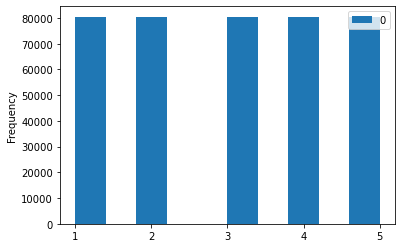

In [11]:
unique, counts = np.unique(ys_flat, return_counts=True)
print(unique, counts)
import pandas as pd

df = pd.DataFrame(ys_flat)
df.plot.hist(xticks=[1, 2, 3, 4, 5])